### Import packages

In [2]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import spacy 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import sys
import os

# Définition du chemin du répertoire courant
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from processing.data_handler import DataHandler
from processing.text_preprocessor import TextPreprocessor
from processing.restaurant_classifier import RestaurantClassifier
from processing.review_clusterer import ReviewClusterer
from processing.sentiment_analyzer import SentimentAnalyzer
from processing.visualizer import Visualizer
from processing.keyword_extractor import KeywordExtractor

In [3]:
# Chemin vers la DB
db_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'database.db'))

# Connexion à la base de données
conn = sqlite3.connect(db_path)

# Vérifier la connexion
print("Connexion réussie à la base de données")

Connexion réussie à la base de données


In [ ]:
# afficher les tables de la base de données
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

              name
0   arrondissement
1       restaurant
2  sqlite_sequence
3             avis


In [4]:
# recuperer les données de restaurant 
query = "SELECT * FROM restaurant"

infos_resto = pd.read_sql_query(query, conn)


In [5]:
# recuperer les avis par restaurant
query = "SELeCT * FROM avis"
avis = pd.read_sql_query(query, conn)

In [6]:
arrondissement = "SELECT * FROM arrondissement"
arrondissement = pd.read_sql_query(arrondissement, conn)

In [6]:
# fermer la connexion
conn.close()

In [7]:
def combine_tables(avis, infos_resto, arrondissement):
    """
    Combine les tables avis, infos_resto et arrondissement en effectuant des jointures successives.

    Paramètres :
        - avis (pd.DataFrame) : Table contenant les avis.
        - infos_resto (pd.DataFrame) : Table contenant les informations des restaurants.
        - arrondissement (pd.DataFrame) : Table contenant les informations des arrondissements.

    Retourne :
        - pd.DataFrame : Table finale combinée avec les informations des avis, des restaurants et des arrondissements.
    """
    # Jointure entre avis et infos_resto
    combined = pd.merge(
        avis, 
        infos_resto, 
        left_on='id_restaurant', 
        right_on='id', 
        how='left', 
        suffixes=('_avis', '_resto')  # Renommage des colonnes conflictuelles
    )

    # Jointure avec arrondissement
    final_table = pd.merge(
        combined, 
        arrondissement, 
        on='arrondissement', 
        how='inner'
    )

    # Supprimer la colonne id_restaurant pour éviter les doublons
    final_table = final_table.drop(columns=['id_restaurant'])

    # Renommer les colonnes pour plus de clarté
    final_table = final_table.rename(columns={
        'note': 'note_avis',
        'note_moyenne': 'note_moyenne_resto',
        'nom': 'nom_resto',
    })

    return final_table


In [10]:
data = combine_tables(avis, infos_resto, arrondissement)

In [12]:
# Afficher la liste des colonnes
print(data.columns)

Index(['id_avis', 'date', 'note_avis', 'commentaire', 'id_resto', 'nom_resto',
       'type_cuisine', 'fourchette_prix', 'adresse', 'note_moyenne_resto',
       'description', 'arrondissement', 'latitude', 'longitude',
       'taux_menage_imposable', 'mediane_niveau_de_vie', 'taux_pauvrete'],
      dtype='object')


In [17]:
# les valeurs uniuqes de la colonne fourchete de prix
print(data['fourchette_prix'].unique())

[None '16,00\xa0€-38,00\xa0€' '13,00\xa0€-46,00\xa0€'
 '7,00\xa0€-29,00\xa0€' '15,00\xa0€-23,00\xa0€' '7,00\xa0€-21,00\xa0€'
 '8,00\xa0€-13,00\xa0€' '26,00\xa0€-42,00\xa0€' '9,00€-15,00€'
 '15,00€-30,00€' '16,00€-27,00€' '22,00€-33,00€' '10,00€-38,00€'
 'Française, Européenne, Moderne' '17,00€-46,00€'
 'Française, Européenne, Saine' 'Française']


In [18]:
# Remplacer les valeurs spécifiques dans la colonne fourchette_prix par None
data['fourchette_prix'] = data['fourchette_prix'].replace(
    ['Française, Européenne, Moderne', 'Française, Européenne, Saine', 'Française'], 
    None
)

# Séparer les données de la colonne fourchette_prix en deux colonnes min_prix et max_prix
data[['min_prix', 'max_prix']] = data['fourchette_prix'].str.split('€-', expand=True)

# Supprimer le signe € dans les colonnes min_prix et max_prix
data['min_prix'] = data['min_prix'].str.replace('€', '')
data['max_prix'] = data['max_prix'].str.replace('€', '')

# Remplacer la , par . dans les colonnes min_prix et max_prix
data['min_prix'] = data['min_prix'].str.replace(',', '.')
data['max_prix'] = data['max_prix'].str.replace(',', '.')

# afficher les colonnes fourchette_prix, min_prix et max_prix non nulles pour vérifier les modifications
print(data[['fourchette_prix', 'min_prix', 'max_prix']].dropna())

# transforemer le type des colonnes min_prix et max_prix en float
data['min_prix'] = data['min_prix'].astype(float)
data['max_prix'] = data['max_prix'].astype(float)


[None '16,00\xa0€-38,00\xa0€' '13,00\xa0€-46,00\xa0€'
 '7,00\xa0€-29,00\xa0€' '15,00\xa0€-23,00\xa0€' '7,00\xa0€-21,00\xa0€'
 '8,00\xa0€-13,00\xa0€' '26,00\xa0€-42,00\xa0€' '9,00€-15,00€'
 '15,00€-30,00€' '16,00€-27,00€' '22,00€-33,00€' '10,00€-38,00€'
 '17,00€-46,00€']


In [30]:
# colonnes notes restos et avis et av
print(data[['note_moyenne_resto', 'note_avis']].head())

# remplacer les , par . dans les colonnes note_moyenne_resto et note_avis
data['note_moyenne_resto'] = data['note_moyenne_resto'].str.replace(',', '.')
data['note_avis'] = data['note_avis'].str.replace(',', '.')
data['note_moyenne_resto'] = data['note_moyenne_resto'].astype(float)
data['note_avis'] = data['note_avis'].astype(float)


  note_moyenne_resto note_avis
0                2,5       2,0
1                2,5       5,0
2                2,5       2,0
3                2,5       2,0
4                2,5       2,0


In [7]:
dh = DataHandler()

# Combiner et agréger les données
aggregated_data = dh.combine_and_aggregate(avis, infos_resto)

In [8]:
# nom des colonnes de 
print(aggregated_data.columns)

Index(['id_restaurant', 'commentaire', 'nom', 'type_cuisine',
       'fourchette_prix', 'description', 'adresse', 'note_moyenne'],
      dtype='object')


In [9]:
# Prétraitement des commentaires
tp = TextPreprocessor()
aggregated_data['commentaire'] = tp. preprocess_reviews(aggregated_data['commentaire'])


In [10]:
# afficher les commentaires prétraités
print(aggregated_data['commentaire'])

0        quantité garniture galett minable mini morceal...
1        juste après cinéma déjeuner famille deux enfan...
2        restaurer sans intérêt crêpe saler très médioc...
3        demander crêpe jour bah pendant vacance comme ...
4        absolument aucun intérêt culinaire crêpe sucre...
                               ...                        
13796    visiter lyon durer fête lumière viller florent...
13797    petit bijou restaurer long marche jusqu sommet...
13798    meilleur hôtel lyon piscine jacuzzi meilleur v...
13799    emplacement service équipement incroyabler cha...
13800    prendre menu dégustation bien penser magnifiqu...
Name: commentaire, Length: 13801, dtype: object


In [11]:
# Sauvegarde des données agrégées dans un fichier CSV
dh.save_preprocessed_data(aggregated_data, "../data/dataClean/restaurants_data.csv")
print("Les données ont été sauvegardées dans 'restaurants_data.csv'.")

Les données ont été sauvegardées dans 'restaurants_data.csv'.


In [12]:
# Sauvegarde des données agrégées dans une base SQLite
dh.save_to_sqlite(aggregated_data, "../data/dataClean/restaurants.db", "restaurants_table")
print("Les données ont été sauvegardées dans la base SQLite 'restaurants.db'.")

Les données ont été sauvegardées dans la base SQLite 'restaurants.db'.


In [13]:
# Analyse des sentiments
analyzer = SentimentAnalyzer()

In [14]:
# Analyse individuelle des avis
reviews = aggregated_data['commentaire'].tolist()
sentiments = analyzer.analyze_sentiments(reviews, join=False)

print("\nAnalyse des sentiments par avis:")
for i, sentiment in enumerate(sentiments):
    print(f"\nAvis {i+1}:")
    print(f"Polarité: {sentiment['Polarité']:.4f}")
    print(f"Subjectivité: {sentiment['Subjectivité']:.4f}")


Analyse des sentiments par avis:

Avis 1:
Polarité: 0.0000
Subjectivité: 0.0000

Avis 2:
Polarité: 0.0000
Subjectivité: 0.0000

Avis 3:
Polarité: 0.0000
Subjectivité: 0.0000

Avis 4:
Polarité: 0.1000
Subjectivité: 0.4000

Avis 5:
Polarité: 0.0000
Subjectivité: 0.0000

Avis 6:
Polarité: -0.0375
Subjectivité: 0.4875

Avis 7:
Polarité: 0.2619
Subjectivité: 0.5238

Avis 8:
Polarité: 0.0000
Subjectivité: 0.0000

Avis 9:
Polarité: 0.0000
Subjectivité: 0.0000

Avis 10:
Polarité: 0.0000
Subjectivité: 0.0000

Avis 11:
Polarité: 0.2143
Subjectivité: 0.5714

Avis 12:
Polarité: 0.0000
Subjectivité: 0.0000

Avis 13:
Polarité: 0.0000
Subjectivité: 0.0000

Avis 14:
Polarité: 0.0000
Subjectivité: 0.0000

Avis 15:
Polarité: 0.2143
Subjectivité: 0.5714

Avis 16:
Polarité: 0.4000
Subjectivité: 1.0000

Avis 17:
Polarité: 0.0000
Subjectivité: 0.0000

Avis 18:
Polarité: 0.0000
Subjectivité: 0.0000

Avis 19:
Polarité: 0.0000
Subjectivité: 0.0000

Avis 20:
Polarité: 0.0000
Subjectivité: 0.0000

Avis 21:
Pola

In [15]:
# Analyse par restaurant
restaurant_sentiments = analyzer.analyze_by_restaurant(aggregated_data)
sentiments_df = pd.DataFrame(restaurant_sentiments)
moyenne_par_restaurant = sentiments_df.groupby('nom').agg({
    'polarité': 'mean',
    'subjectivité': 'mean'
})

print("\nAnalyse des sentiments par restaurant:")
for nom, row in moyenne_par_restaurant.iterrows():
    print(f"\nRestaurant: {nom}")
    print(f"Polarité moyenne: {row['polarité']:.4f}")
    print(f"Subjectivité moyenne: {row['subjectivité']:.4f}")


Analyse des sentiments par restaurant:

Restaurant: Bistrot Orcia
Polarité moyenne: 0.3533
Subjectivité moyenne: 0.4955

Restaurant: Brasserie L'Ouest
Polarité moyenne: 0.2339
Subjectivité moyenne: 0.4353

Restaurant: Crêperie Amélie
Polarité moyenne: 0.0671
Subjectivité moyenne: 0.3003

Restaurant: Flair
Polarité moyenne: 0.3099
Subjectivité moyenne: 0.4822

Restaurant: Frazarin Bistrot Franco Italien
Polarité moyenne: 0.3512
Subjectivité moyenne: 0.4970

Restaurant: Kaffee Berlin Sans-Souci
Polarité moyenne: 0.1684
Subjectivité moyenne: 0.3878

Restaurant: L'Argot
Polarité moyenne: 0.2368
Subjectivité moyenne: 0.4340

Restaurant: L'affreux Jojo
Polarité moyenne: 0.2657
Subjectivité moyenne: 0.3919

Restaurant: La Fabryk Lyon
Polarité moyenne: 0.1571
Subjectivité moyenne: 0.3625

Restaurant: La Source
Polarité moyenne: 0.2835
Subjectivité moyenne: 0.4226

Restaurant: La Table de Max
Polarité moyenne: 0.3731
Subjectivité moyenne: 0.5263

Restaurant: Le Bistro Autrement
Polarité moyenn

In [16]:
# Extraction des mots-clés pour chaque avis
extractor = KeywordExtractor()
reviews = aggregated_data['commentaire'].tolist()
keywords = extractor.extract_keywords(reviews)

print("\nMots-clés par avis:")
for review_id, kw in keywords.items():
    print(f"\n{review_id}:")
    for word, score in kw:
        print(f"  - {word}: {score:.4f}")


Mots-clés par avis:

Avis 1:
  - jambon: 0.3741
  - croire: 0.3308
  - bon accueil: 0.3108
  - blanc: 0.3035
  - quantité: 0.2906

Avis 2:
  - enfant: 0.5078
  - agréable service: 0.3212
  - famille: 0.2715
  - service très: 0.2419
  - note: 0.2394

Avis 3:
  - crêpe: 0.6312
  - trop: 0.2678
  - intérêt: 0.2389
  - cuite: 0.2385
  - sucrer: 0.2374

Avis 4:
  - comme: 0.4315
  - quand: 0.3272
  - repartir: 0.2561
  - est: 0.2492
  - pourquoi: 0.2372

Avis 5:
  - intérêt: 0.6057
  - sucrer: 0.3009
  - revanche: 0.2907
  - glace: 0.2891
  - crêpe: 0.2667

Avis 6:
  - long: 0.7114
  - dessus: 0.3157
  - déception: 0.2553
  - élevé: 0.2532
  - présenter: 0.2523

Avis 7:
  - sympa: 0.3997
  - centre: 0.3423
  - restauration: 0.3225
  - qualité produit: 0.3189
  - chercher: 0.2997

Avis 8:
  - beaucoup trop: 0.3304
  - serveuse: 0.3304
  - léger: 0.3105
  - crêpe: 0.2939
  - croire: 0.2922

Avis 9:
  - crêpe: 0.7461
  - canard: 0.1706
  - préparation: 0.1689
  - préciser: 0.1662
  - seulemen

In [17]:
# Agrégation des mots-clés
global_keywords = extractor.aggregate_keywords(reviews)
print("\nMots-clés globaux:")
for word, score in global_keywords:
    print(f"- {word}: {score:.4f}")


Mots-clés globaux:
- très: 123.9285
- pizza: 105.6145
- viande: 81.6366
- bon: 79.5463
- super: 74.6087
- tre: 68.2761
- tout: 66.2587
- plus: 66.1587
- peu: 63.9048
- toujours: 61.9965


In [18]:
# ReviewClusterer

clusterer = ReviewClusterer()

reviews = aggregated_data['commentaire'].tolist()
clusters = clusterer.cluster_reviews(reviews)

print("\nAnalyse des clusters:")
print(clusters)


Analyse des clusters:
     Cluster  Nombres_avis  Polarité  Subjectivité  \
0  Cluster 1          3018  0.372367      0.732837   
1  Cluster 2          5744  0.372919      0.733783   
2  Cluster 3          5039  0.409227      0.736482   

                                           Mots_Clés  
0  pizza (22.48), toujours (20.41), plus (17.97),...  
1  pizza (44.65), viande (37.54), tre (33.88), su...  
2  très (34.92), pizza (30.31), super (28.16), pl...  


In [19]:
# Visualizer
viz = Visualizer()

2025-01-10 22:36:19,727 - processing.visualizer - INFO - Génération du nuage de mots...
2025-01-10 22:36:25,029 - processing.visualizer - ERROR - Erreur lors de la génération du nuage de mots: [WinError 3] Le chemin d’accès spécifié est introuvable: ''


FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: ''

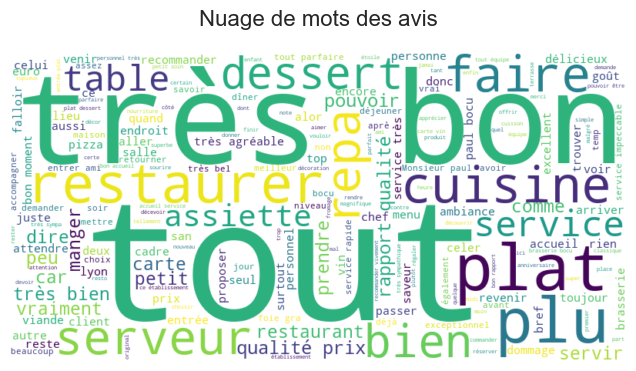

In [20]:
# Génération du nuage de mots
all_text = ' '.join(aggregated_data['commentaire'])
viz.generate_wordcloud(
    all_text,
    title="Nuage de mots des avis",
    output_file="wordcloud.png"
)

2025-01-10 22:38:01,845 - processing.visualizer - INFO - Distribution des sentiments sauvegardée dans sentiments.png


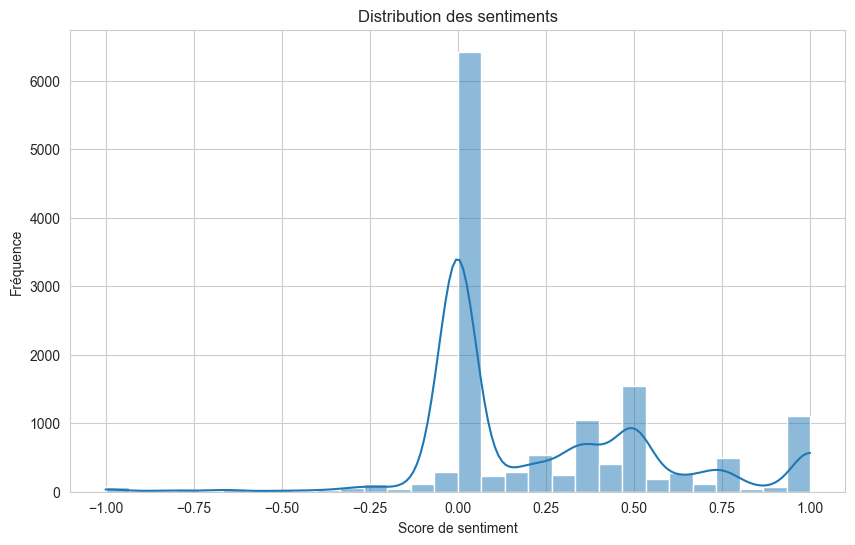

In [21]:
# Distribution des sentiments
sentiments = [s['Polarité'] for s in analyzer.analyze_sentiments(aggregated_data['commentaire'].tolist(), join=False)]
viz.plot_sentiment_distribution(
    sentiments,
    title="Distribution des sentiments",
    output_file="sentiments.png"
)